In [1]:
import numpy as np #importing packages
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset
from plotting import show_img, loss_plots, plot_random_images, plot_image_comparison, plot_latent
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

data_train = OwnDataset(train=True, transform=tf)
data_test = OwnDataset(train=False, transform=tf)

train_loader = DataLoader(data_train, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(data_test, batch_size=64, shuffle=True, pin_memory=cuda)



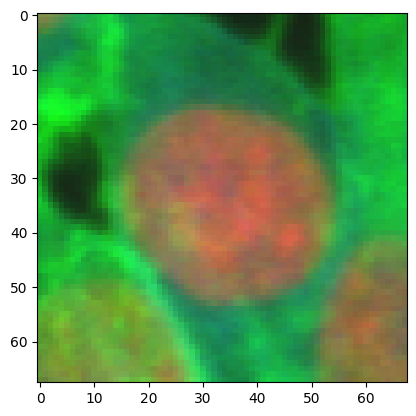

In [3]:
# get a sample image from the dataset
sample = data_train[612][0]

# show the image
show_img(sample.view(3,68,68))


In [4]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([64, 13872]) torch.Size([64])


# VAE

In [5]:
from models import VAE_CELL_linear
from loss_functions import loss_function
# from loss_functions import loss_function_logvar as loss_function

model = VAE_CELL_linear(input_dim=68*68*3, hidden_dim=512, latent_dim=2)
print(model)

if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-3)


VAE_CELL_linear(
  (encoder): Sequential(
    (0): Linear(in_features=13872, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (mu): Linear(in_features=512, out_features=2, bias=True)
  (logvar): Linear(in_features=512, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=13872, bias=True)
    (5): Sigmoid()
  )
)


In [6]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat = output["x_hat"]
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([64, 13872])
x_hat.shape: torch.Size([64, 13872])


## Training

Epoch 1/5, loss: 17438.6650714485, mse: 17035.227185307718, kld: 403.43795313458054


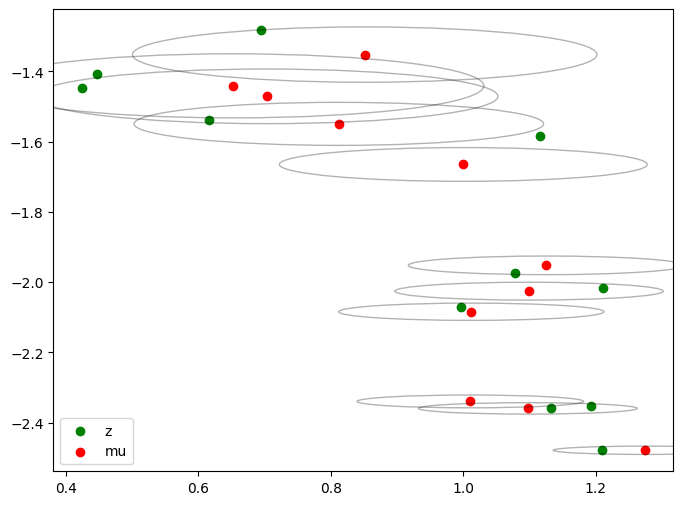

Epoch 2/5, loss: 12369.482340909997, mse: 11951.631178252552, kld: 417.8511562736667


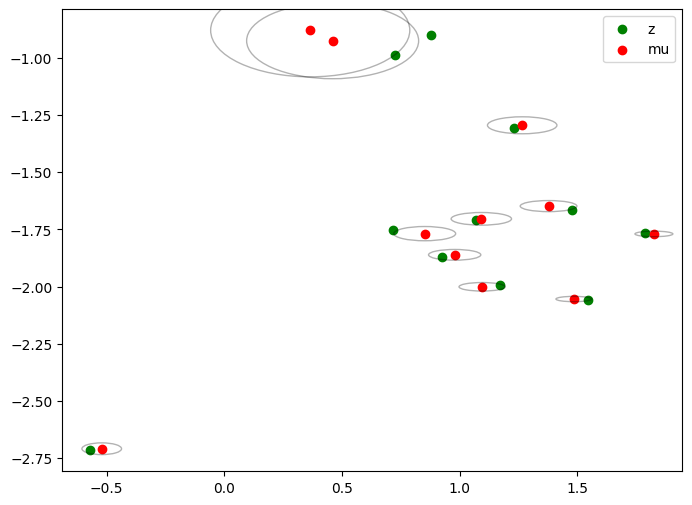

Epoch 3/5, loss: 11673.549112125318, mse: 11245.247993313536, kld: 428.3010786406848


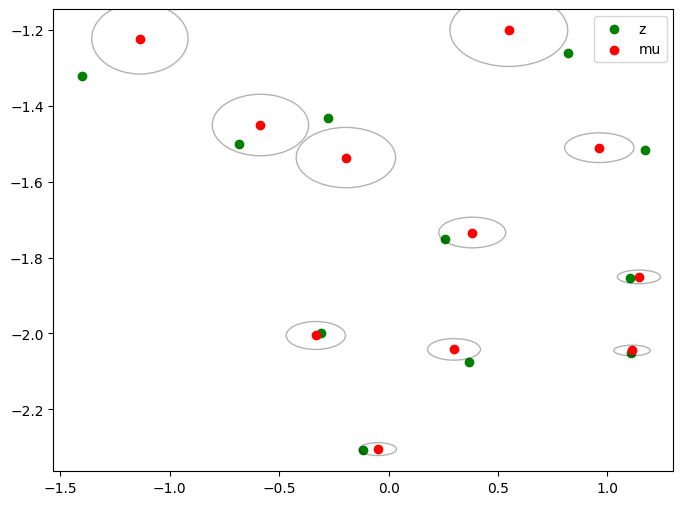

Epoch 4/5, loss: 11505.302756796078, mse: 11082.119815748565, kld: 423.18293357382015


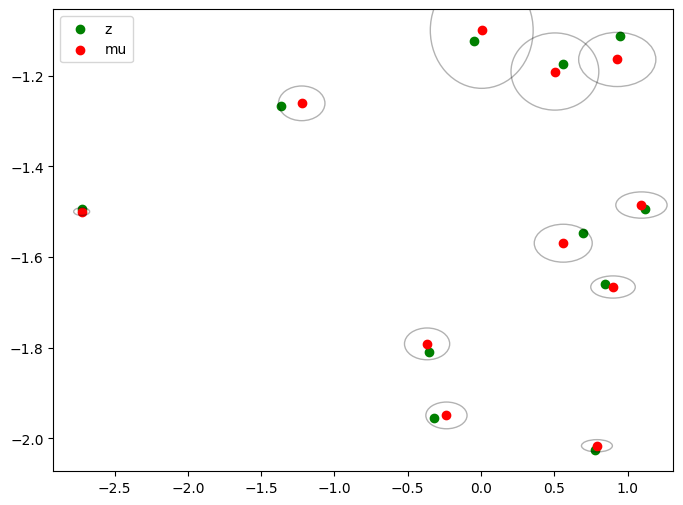

Epoch 5/5, loss: 11491.94382274394, mse: 11071.420562121333, kld: 420.52325462808415


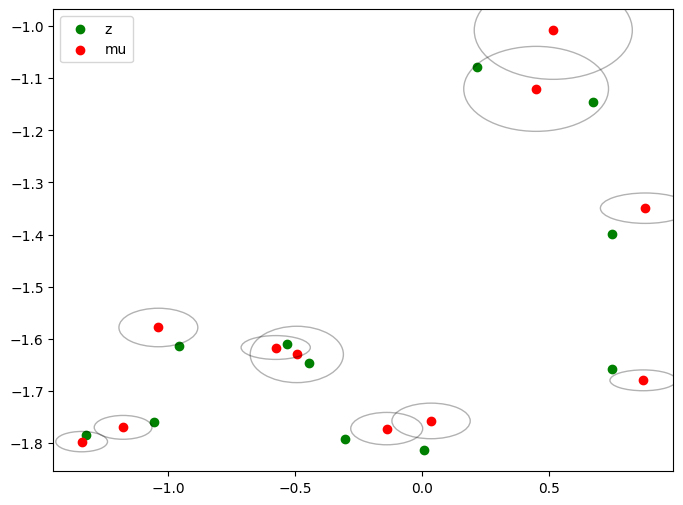

In [8]:
num_epochs = 5

train_loss = []
train_mse_loss = []
train_kld_loss = []
valid_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        output = model(x)
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
    
    # with torch.no_grad():
    #     model.eval()
    #     x, y = next(iter(test_loader))
    #     if cuda:
    #         x = x.cuda()
    #     output = model(x)

        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    # print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse: {train_mse_loss[-1]}, kld: {train_kld_loss[-1]}")
    plot_latent(output)



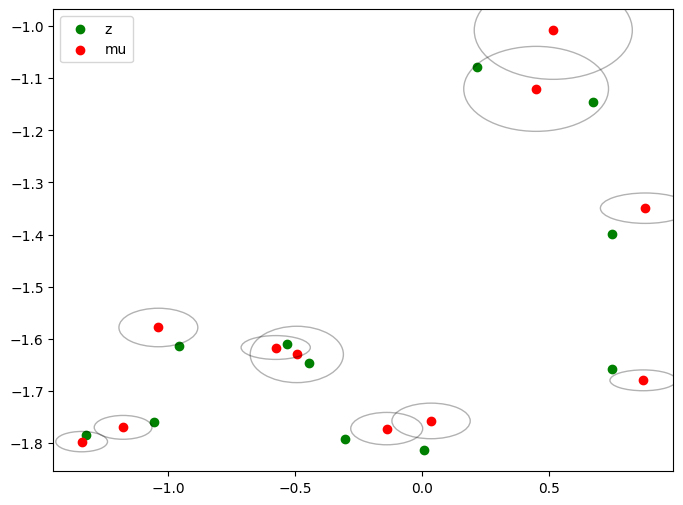

In [9]:
plot_latent(output)


## Plots

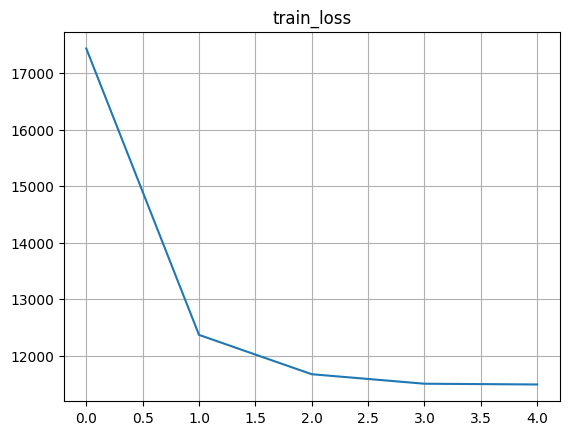

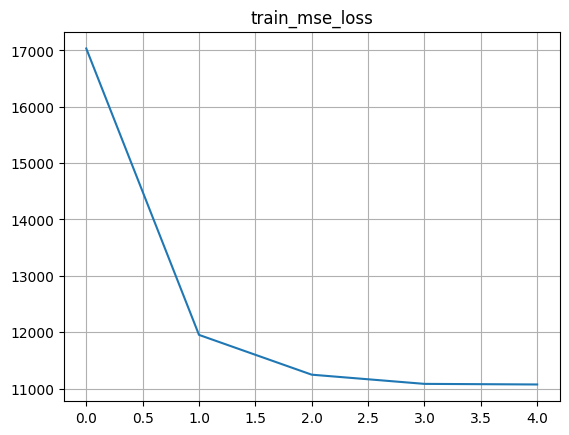

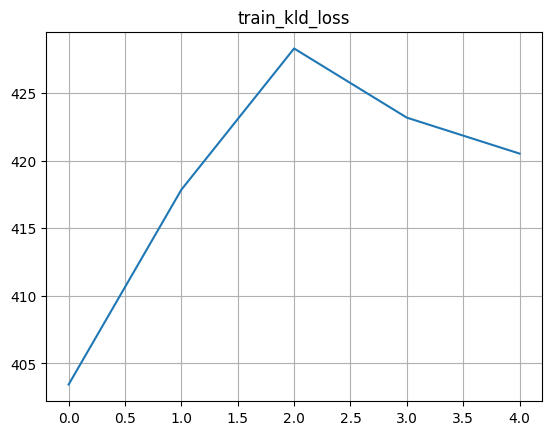

In [10]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss


loss_plots(loss_data, invidual_plots=True)

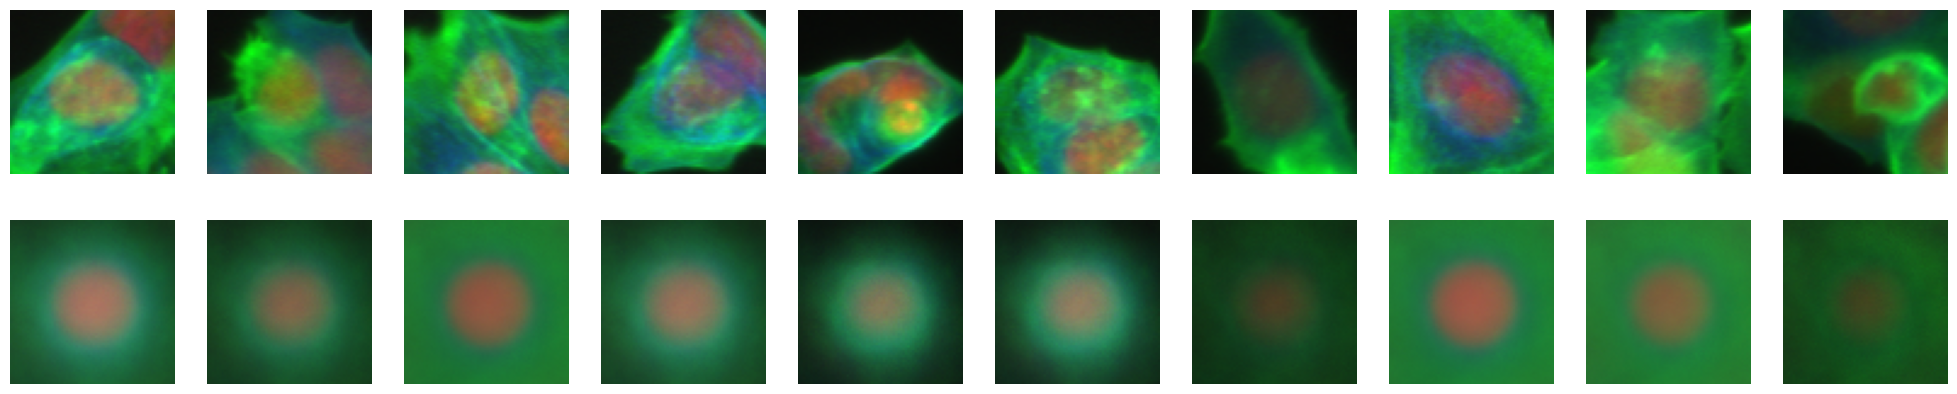

In [11]:
# test the model
plot_image_comparison(model, test_loader, cuda, img_shape=(3,68,68))



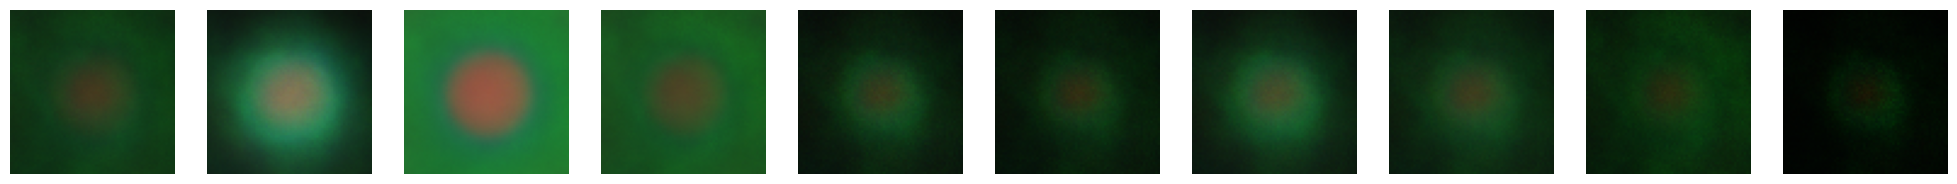

In [12]:
# plot random images generated from the model
plot_random_images(model, n=10, img_shape=(3,68,68), cuda=cuda)

In [13]:
from inference import Inference

inference = Inference(model, test_loader)

In [14]:
samples = inference.samples


In [15]:
sigma

tensor([[0.1037, 0.0246],
        [0.1029, 0.0228],
        [0.1180, 0.0194],
        [0.0759, 0.0152],
        [0.0910, 0.0152],
        [0.2077, 0.0628],
        [0.0946, 0.0207],
        [0.1225, 0.0361],
        [0.0874, 0.0133],
        [0.1902, 0.0543],
        [0.0680, 0.0130]], device='cuda:0', grad_fn=<ExpBackward0>)